In [7]:
from __future__ import print_function, division


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import copy
import json
import importlib
import glob
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch

from utils import (
    show_sbs,
    load_config,
    _print,
)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [8]:
torch.manual_seed(0)


In [9]:
!nvidia-smi

Tue Aug 16 10:50:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8    26W / 350W |     72MiB / 24267MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
CONFIG_NAME = "isic2018_unet.yaml"
CONFIG_FILE_PATH = os.path.join("./configs", CONFIG_NAME)

In [11]:
config = load_config(CONFIG_FILE_PATH)
# _print("Config:", "info_underline")
# print(json.dumps(config, indent=2))
# print(20*"~-", "\n")

## Functions

In [12]:
def show_img_pred_gt(img, pred, gt, figsize=(8,4)):
    _, axs = plt.subplots(1, 3, figsize=figsize)
    x = img.squeeze().permute([1, 2, 0]).to('cpu').numpy().astype(np.float)
    y = gt.squeeze().detach().to('cpu').numpy().astype(np.float)
    p = pred.squeeze().detach().to('cpu').numpy().astype(np.float)
    axs[0].imshow(x); axs[0].set_title('image')
    axs[1].imshow(p); axs[1].set_title('pred')
    axs[2].imshow(y); axs[2].set_title('gt')
    plt.show()
    

def plot_loss_curves(tr, vl):
#     plt.figure(figsize=(12, 4))
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("DiceLoss")
    plt.plot(range(len(tr)), tr, 'r')
    plt.plot(range(len(vl)), vl, 'b')
    plt.legend(['Traning', 'Validation'])
    plt.show()

### dataset and dataloader

In [13]:
from datasets.isic import ISIC2018TrainingDataset
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

Length of trainig_dataset:	1815
Length of validation_dataset:	259
Length of test_dataset:		520
Training


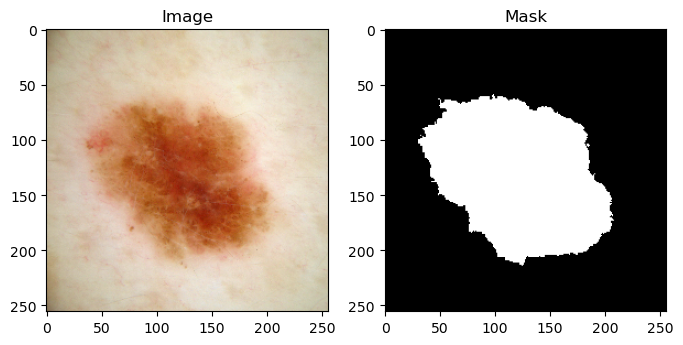

Validation


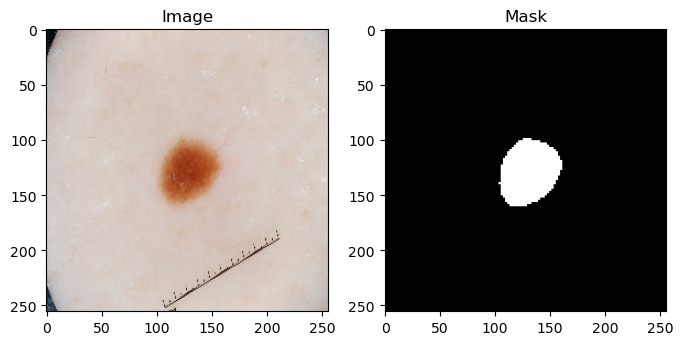

In [14]:
# ------------------- params --------------------
INPUT_SIZE = config['dataset']['input_size']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# ----------------- transforms ------------------
# transform for image
img_transform = transforms.Compose([
    transforms.Resize(
        size=[INPUT_SIZE, INPUT_SIZE], 
        interpolation=transforms.functional.InterpolationMode.BILINEAR
    ),
])
# transform for mask
msk_transform = transforms.Compose([
    transforms.Resize(
        size=[INPUT_SIZE, INPUT_SIZE], 
        interpolation=transforms.functional.InterpolationMode.NEAREST
    ),
])
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# ----------------- dataset --------------------
# preparing training dataset
train_dataset = ISIC2018TrainingDataset(
    img_transform=img_transform,
    msk_transform=msk_transform
)

# We consider 1815 samples for training, 259 samples for validation and 520 samples for testing
# !cat ~/deeplearning/skin/Prepare_ISIC2018.py

indices = list(range(len(train_dataset)))

# split indices to: -> train, validation, and test
tr_indices = indices[0:1815]
vl_indices = indices[1815:1815+259]
te_indices = indices[1815+259:2594]

# create new datasets from train dataset as training, validation, and test
tr_dataset = Subset(train_dataset, tr_indices)
vl_dataset = Subset(train_dataset, vl_indices)
te_dataset = Subset(train_dataset, te_indices)
print(f"Length of trainig_dataset:\t{len(tr_dataset)}")
print(f"Length of validation_dataset:\t{len(vl_dataset)}")
print(f"Length of test_dataset:\t\t{len(te_dataset)}")


# prepare train dataloader
tr_dataloader = DataLoader(tr_dataset, **config['data_loader']['train'])

# prepare validation dataloader
vl_dataloader = DataLoader(vl_dataset, **config['data_loader']['validation'])

# prepare test dataloader
te_dataloader = DataLoader(te_dataset, **config['data_loader']['test'])

# -------------- test -----------------
# test and visualize the input data
for img, msk in tr_dataloader:
    print("Training")
    show_sbs(img[0], msk[0])
    break
    
for img, msk in vl_dataloader:
    print("Validation")
    show_sbs(img[1], msk[1])
    break

### Device

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch device: {device}")

Torch device: cuda


### model and config

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchmetrics
from models.unet import Unet

from torch.optim import (
  Adam
)

from losses import (
    DiceLoss
)

### validate

In [17]:
def get_tf_pn(pred, gt, ts=[]):
    ts = [t.lower() for t in ts]
    res = []
    for w in ts:
        # true-positive
        if w=='tp':
            r = ((pred==True)+(gt==True))==2
        # true-negetive
        elif w=='tn':
            r = ((pred==False)+(gt==False))==2
        # false-positive
        elif w=='fp':
            r = ((pred==True)+(gt==False))==2
        # false-negetive
        elif w=='fn':
            r = ((pred==False)+(gt==True))==2
        res.append(r)
    return res
         

def get_accuracy(pred, gt, threshold=0.5):
    pred = pred > threshold
    gt = gt == torch.max(gt)
    corr = torch.sum(pred==gt)
    tensor_size = pred.size(0)*pred.size(1)*pred.size(2)*pred.size(3)
    acc = float(corr)/float(tensor_size)
    return acc


def get_sensitivity(pred, gt, threshold=0.5):
    # Sensitivity == Recall
    pred = pred > threshold
    gt = gt == torch.max(gt)
    tp, fn = get_tf_pn(pred, gt, ['tp', 'fn'])
    se = float(torch.sum(tp))/(float(torch.sum(tp+fn)) + 1e-6)     
    return se


def get_specificity(pred, gt, threshold=0.5):
    pred = pred > threshold
    gt = gt == torch.max(gt)
    tn, fp = get_tf_pn(pred, gt, ['tn', 'fp'])
    sp = float(torch.sum(tn))/(float(torch.sum(tn+fp)) + 1e-6)
    return sp


def get_precision(pred, gt, threshold=0.5):
    pred = pred > threshold
    gt = gt == torch.max(gt)
    tp, fp = get_tf_pn(pred, gt, ['tp', 'fp'])
    pc = float(torch.sum(tp))/(float(torch.sum(tp+fp)) + 1e-6)
    return pc


def get_f1(pred, gt, threshold=0.5):
    # Sensitivity == Recall
    se = get_sensitivity(pred, gt, threshold=threshold)
    pc = get_precision(pred, gt, threshold=threshold)
    f1 = 2*se * pc/(se+pc + 1e-6)
    return f1


def get_js(pred, gt, threshold=0.5):
    # js : jaccard similarity
    pred = pred > threshold
    gt = gt == torch.max(gt)
    Inter = torch.sum((pred+gt)==2)
    Union = torch.sum((pred+gt)>=1)
    js = float(Inter)/(float(Union) + 1e-6)
    return js


def get_dc(pred,gt,threshold=0.5):
    # dc : dice coefficient
    pred = pred > threshold
    gt = gt == torch.max(gt)
    Inter = torch.sum((pred+gt)==2)
    dc = float(2*Inter)/(float(torch.sum(pred)+torch.sum(gt)) + 1e-6)
    return dc


In [18]:
get_tf_pn(pred, gt, ts=[])

NameError: name 'pred' is not defined

In [ ]:
get_accuracy(preds, msks)

In [13]:
get_sensitivity(preds, msks, 0.0)

NameError: name 'preds' is not defined

In [27]:
def get_tf_pn(pred, gt, ts=[]):
    ts = [t.lower() for t in ts]
    res = []
    for w in ts:
        # true-positive
        if w=='tp':
            r = ((pred==True)+(gt==True))==2
        # true-negetive
        elif w=='tn':
            r = ((pred==False)+(gt==False))==2
        # false-positive
        elif w=='fp':
            r = ((pred==True)+(gt==False))==2
        # false-negetive
        elif w=='fn':
            r = ((pred==False)+(gt==True))==2
        res.append(r)
    return res

pred = preds > 0.2
gt = msks == torch.max(msks)
tp, fn, tn, fp = get_tf_pn(pred, gt, ['tp', 'fn', 'tn', 'fp'])
se = float(torch.sum(tp))/(float(torch.sum(tp+fn)) + 1e-6)     
se

0.0

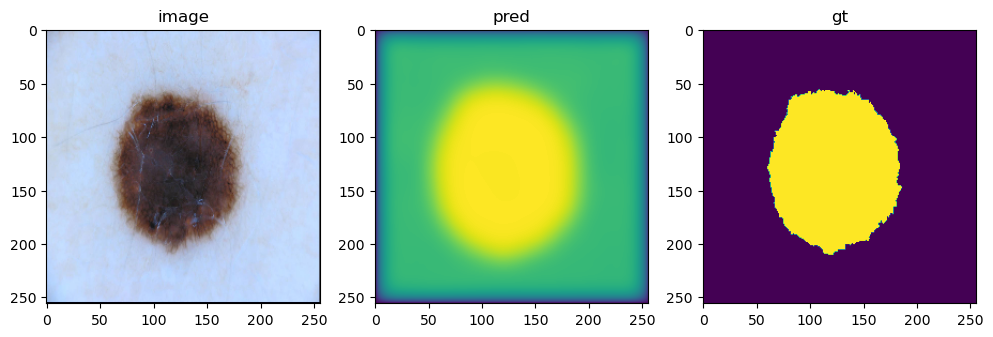

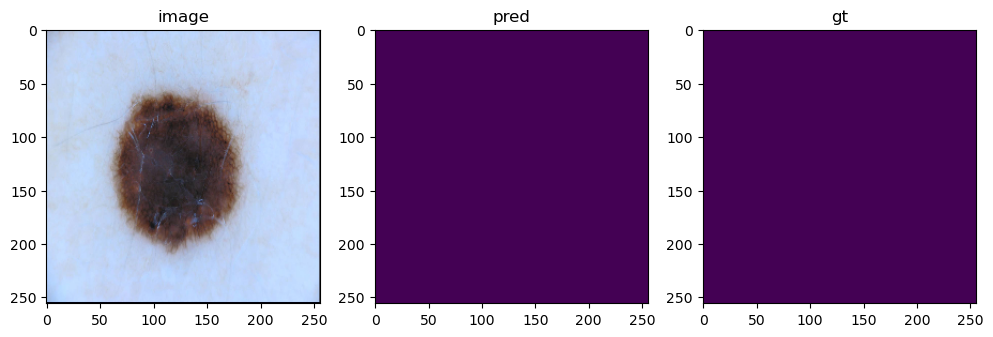

In [46]:
# model.eval()
# with torch.no_grad():
# #         print('validating...')

#     # calculate metrics per batch
#     evaluator = Evaluator()
#     losses = []
#     cnt = 0.
#     iterator = tqdm(enumerate(vl_dataloader))
#     for batch, (imgs, msks) in iterator:
#         cnt += msks.shape[0]

#         imgs = imgs.to(device)
#         msks = msks.to(device)

#         preds = model(imgs)
#         metrics = evaluator.step(preds=preds,gts=msks,threshold=0.5)
        
#         # print the final results
#         loss = np.sum(losses)/cnt
#         t_m = evaluator.calc_metrics_totally()
#         _ams = ', '.join([f'{evaluator.summaries_metrics(k)}: {v:0.5f}' for k,v in t_m.items()])
#         iterator.set_description(f"Validation_result) {_ams}")
        
idx = 1
show_img_pred_gt(imgs[idx], preds[idx], msks[idx], figsize=(12,4))

tp, tn, fp, fn = get_tf_pn(preds>0.5, msks>0.5, ts=['tp', 'tn', 'fp', 'fn'])

tp = ( (pred==True) + (gt==True) ) == 2
        
show_img_pred_gt(imgs[idx], tp[idx], tn[idx], figsize=(12,4))

In [61]:
p_bin = preds[0]>0.6
g_bin = msks[0]>0.5

tp = ( (p_bin==True) + (g_bin==True) ) == 2
( (p_bin==True) + (g_bin==True) ).unique()

tensor([False,  True], device='cuda:0')

In [53]:
preds[0]

tensor([[[0.5345, 0.5444, 0.5529,  ..., 0.5612, 0.5541, 0.5436],
         [0.5354, 0.5526, 0.5674,  ..., 0.5808, 0.5682, 0.5507],
         [0.5363, 0.5631, 0.5837,  ..., 0.5997, 0.5808, 0.5586],
         ...,
         [0.5329, 0.5569, 0.5761,  ..., 0.5951, 0.5787, 0.5620],
         [0.5334, 0.5506, 0.5647,  ..., 0.5771, 0.5659, 0.5544],
         [0.5286, 0.5378, 0.5451,  ..., 0.5504, 0.5463, 0.5438]]],
       device='cuda:0')

In [62]:
True + True

2

In [18]:
# import metrics for evaluation
from metrics import (
#     get_accuracy,
#     get_sensitivity,
#     get_specificity, 
#     get_precision, 
#     get_f1,
#     get_js, # jaccard similarity
#     get_dc, # dice coefficient
    Metrics
)

class Evaluator():
    def __init__(
        self, 
        metrics=['accuracy', 'sensitivity', 'specificity', 'precision', 'f1', 'js', 'dc']
    ):
        self.metric_names = metrics
        self.batches_info = []
        self.__mnts_mapper = {'accuracy':'acc','sensitivity':'se','specificity':'sp','precision':'pr'}
        
    def summaries_metrics(self, metric_name):
        try:
            return self.__mnts_mapper[metric_name]
        except:
            return metric_name
    
    def step(self, preds, gts, threshold=0.5):
        metrics = self.calc_metrics(preds, gts, threshold=threshold)
        self.batches_info.append({
            'size': preds.shape[0],
            'metrics': metrics
        })
        return metrics
    
    def reset(self):
        self.batches_info.clear()
        
    def calc_metrics(self, preds, gts, threshold=0.5):
        metrics = {}
        m = Metrics(preds, gts, threshold=threshold)
        for mn in self.metric_names:
            metrics[mn] = eval(f'm.get_{mn}()')
        return metrics

    def calc_metrics_totally(self):
        # calculate metrics totally
        t_m = dict((k, 0) for k in self.batches_info[0]['metrics'].keys())
        for batch_info in self.batches_info:
            sz = batch_info['size']
            for metric_name, metric_value in batch_info['metrics'].items():
                t_m[metric_name] += metric_value * sz
        sum_sz = sum([b['size'] for b in self.batches_info])
        for metric_name in t_m.keys():
            t_m[metric_name] /= sum_sz
        return t_m

In [19]:
def validate(model, criterion, vl_dataloader):
    model.eval()
    with torch.no_grad():
#         print('validating...')
        
        # calculate metrics per batch
        evaluator = Evaluator()
        losses = []
        cnt = 0.
        iterator = tqdm(enumerate(vl_dataloader), leave=None)
        for batch, (imgs, msks) in iterator:
            cnt += msks.shape[0]
            
            imgs = imgs.to(device)
            msks = msks.to(device)
            
            preds = model(imgs)
            loss = criterion(preds, msks)
            losses.append(loss.item())
            
            metrics = evaluator.step(preds=preds,gts=msks,threshold=0.5)
            _cml = f"curr_mean-loss:{np.sum(losses)/cnt:0.5f}"
            _bl = f"batch-loss:{losses[-1]/msks.shape[0]:0.5f}"
            iterator.set_description(f"Validation) batch:{batch+1:04d} -> {_cml}, {_bl}")
        
        # print the final results
        loss = np.sum(losses)/cnt
        t_m = evaluator.calc_metrics_totally()
        _ams = ', '.join([f'{evaluator.summaries_metrics(k)}: {v:0.5f}' for k,v in t_m.items()])
        iterator.set_description(f"Validation_result) {_ams}")
    
    return t_m, loss

In [20]:
def train(
    model, 
    device, 
    tr_dataloader,
    vl_dataloader,
    config,
    save_dir='./',
    save_file_id=None,
):
    tr_prms = config['training']
    EPOCHS = tr_prms['epochs']
  
    criterion = globals()[tr_prms['criterion']['name']](**tr_prms['criterion']['params'])
    optimizer = globals()[tr_prms['optimizer']['name']](model.parameters(), **tr_prms['optimizer']['params'])
    # optimizer = optim.RMSprop(Net.parameters(), lr= float(config['lr']), weight_decay=1e-8, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    # calculate metrics per batch
    evaluator = Evaluator()
    epochs_info = []
    best_vl_loss = np.Inf
    epoch_tqdm = tqdm(range(EPOCHS), nrows=2)
    for epoch in epoch_tqdm:
        model.train()
        
        evaluator.reset()
        tr_iterator = tqdm(enumerate(tr_dataloader), leave=None)
        tr_losses = []
        cnt = 0
        for batch, (imgs, msks) in tr_iterator:
            imgs = imgs.to(device)
            msks = msks.to(device)
            
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, msks)
            loss.backward()
            optimizer.step()
            
            metrics = evaluator.step(
                preds=preds, 
                gts=msks, 
                threshold=0.5
            )
            cnt += imgs.shape[0]
            tr_losses.append(loss.item())
            
            # write details for each training batch
            _cml = f"curr_mean-loss:{np.sum(tr_losses)/cnt:0.5f}"
            _bl = f"mean_batch-loss:{tr_losses[-1]/imgs.shape[0]:0.5f}"
            tr_iterator.set_description(f"Training) batch:{batch+1:04d} -> {_cml}, {_bl}")

#             if cnt>150: break
            
        # validate model
#         tr_iterator.set_description(f"Validation... (tr-loss:{np.sum(tr_losses)/cnt:0.5f})")
        vl_metrics, vl_loss = validate(model, criterion, vl_dataloader)
        if vl_loss < best_vl_loss:
            # find a better model
            best_model = model
            best_vl_loss = vl_loss
        
        # print the final results
        epoch_info = {
            'tr_loss': np.sum(tr_losses)/cnt,
            'vl_loss': vl_loss,
            'tr_metrics': evaluator.calc_metrics_totally(),
            'vl_metrics': vl_metrics
        }
        epochs_info.append(epoch_info)
        
        # write details for this epoch
        _bvl = f'best_vl-loss:{best_vl_loss:0.5f}'
        _ltl = f"last_tr-loss:{epoch_info['tr_loss']:0.5f}"
        _tr_ams = ', '.join([f'tr_{evaluator.summaries_metrics(k)}: {v:0.4f}' for k,v in epoch_info['tr_metrics'].items()])
        _vl_ams = ', '.join([f'vl_{evaluator.summaries_metrics(k)}: {v:0.4f}' for k,v in epoch_info['vl_metrics'].items()])
        
        epoch_tqdm.set_description(f"Epoch:{epoch+1}/{EPOCHS} -> {_bvl}, {_ltl}, {_vl_ams}, {_tr_ams}")
        
#         if cnt>5: break
        
    # save final results
    res = {
        'id': save_file_id,
        'config': config,
        'epochs_info': epochs_info
    }
    fn = f"{save_file_id+'_' if save_file_id else ''}result.json"
    fp = os.path.join(config['model']['save_dir'],fn)
    with open(fp, "w") as write_file:
        json.dump(res, write_file, indent=4)

    # save model's state_dict
    fn = f"{save_file_id if save_file_id else 'model'}_state_dict.pt"
    fp = os.path.join(config['model']['save_dir'],fn)
    torch.save(model.state_dict(), fp)
    
    return model, res

In [21]:
# def test_model(model, modelPath):
#     if not os.path.exists("results"):
#         os.makedirs("results")
#     model.load_state_dict(torch.load(modelPath))
#     model.eval()
#     model = model.to(device)
#     df = pd.DataFrame(columns=classes)
#     with torch.no_grad():
#         for idx, sample in enumerate(dataloader_test):
#             outputs = model(sample['image'].to(device))
#             outputs = softmax(outputs)
#             outputs = outputs.cpu().numpy()
#             df = df.append(
#                 pd.DataFrame(data=outputs, columns=classes))
#         df = df.reset_index()
#         del df['index']
#         df.insert(0, 'image', images['image'])
#     df.to_csv(f'results/test_results.csv', index=False)

In [22]:
# if __name__ == "__main__":
#     model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=9)
#     model, fileName = train_model(model, 16, 0.01, 1, 0, 0, '3')
#     validate(model)
#     test_model(model, fileName)

In [23]:
model = Unet(**config['model']['params'])
torch.cuda.empty_cache()
model = model.to(device)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

os.makedirs(config['model']['save_dir'], exist_ok=True)
model_path = f"{config['model']['save_dir']}/model_state_dict.pt"

if config['model']['load_weights']:
    model.load_state_dict(torch.load(model_path))
    print("Loaded pre-trained weights...")

Number of parameters: 1946881


In [24]:
_ = train(
    model, 
    device, 
    tr_dataloader,
    vl_dataloader,
    config,
    save_dir = config['model']['save_dir'],
    save_file_id = None,
)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

## Prepare dataset